# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv("all_vars.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# def construct_models(): Used for quick testing
#     models = [
#         Model('Ridge',Ridge(),
#               parameters = {'alpha':np.logspace(1,4,2)},
#               importance_func=importance_from_coef
#         ),
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':[10],
#                 'learning_rate':np.logspace(-3,0,2),
#               }
#         ), 
#     ]
#     return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Number of features: 638


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [7]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

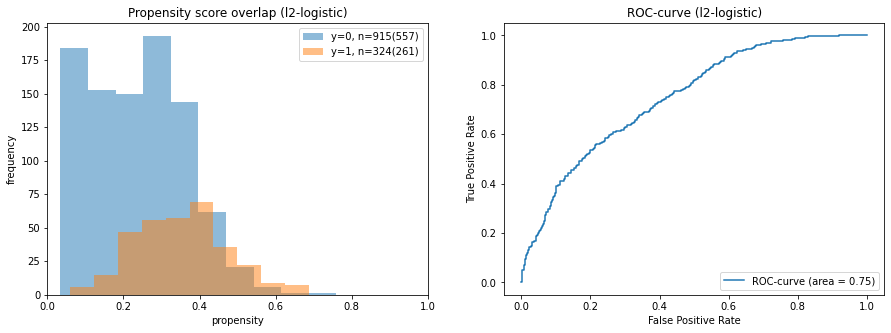

In [8]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [9]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
ahgyob,HF4 Year of Birth,0.047515,0.047515
aicage1,H25 Check age,-0.046980,0.046980
aedqenr,C6 Ever enrolled in a course of study to obtain a qualification,-0.043145,0.043145
aedq524,DV: ASCED 524 Certificate level I - Number of qualifications obtained since leaving school,0.042786,0.042786
ajbocct,DV: Tenure in current occupation (years),-0.036280,0.036280
aehtjbyr,D3a1 Years in paid work,-0.034908,0.034908
ahgage1,DV: Age last birthday at June 30 2001 - person 01,-0.033950,0.033950
atcyng,DV: Age youngest own child (excl. resident foster/step),-0.031407,0.031407
aedq521,DV: ASCED 521 Certificate level II - Number of qualifications obtained since leaving school,0.029348,0.029348
ahhyng,DV: Age of youngest person in household,-0.029211,0.029211


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [17]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=3,
    outercv=5,
    load_from_cache=False
)

Fitting ridge ...Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
Ridge,124.46,17.51,0.17,0.02,0.12,0.03,"-714,205.47","62,634.71","-990,265.31","247,078.99"
gbr,257.17,18.26,0.01,0.00,0.00,0.00,"-852,805.68","62,875.69","-1,113,272.29","245,503.89"


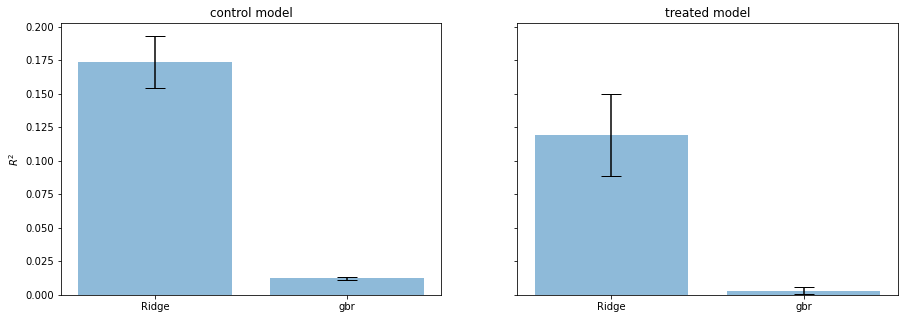

In [11]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [12]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

Ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
awscei,23.177347,3.479891,4.417671,2.094637,-2.096851e+01,2.512025e+00,-25.386182,4.483610
ahgyob,18.856244,1.013095,-8.146687,0.664883,1.478290e+01,8.570489e-01,22.929587,1.240655
aehtjbyr,17.929756,0.968831,9.307460,0.856724,-1.327603e+01,5.568471e-01,-22.583486,1.390747
ahgage1,14.828572,0.324018,4.990356,0.620851,-1.233339e+01,6.172486e-01,-17.323750,0.147334
aicexpct,14.617368,1.129410,-8.570495,3.361318,1.033212e+01,2.069000e+00,18.902615,1.979798
...,...,...,...,...,...,...,...,...
abncob,0.250462,0.225016,0.500924,0.450031,-7.213260e-31,1.132545e-30,-0.500924,0.450031
abncobi,0.227026,0.111289,0.454053,0.222577,2.484658e-30,2.326397e-30,-0.454053,0.222577
ahicobi,0.223486,0.160009,0.446972,0.320017,3.376030e-30,3.673666e-30,-0.446972,0.320017


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [13]:
def extract_params(estimator):
    return estimator.coef_

def bootstrapped_cross_val(
    optimisation_metric,
    extract_params_func,
    inner_cv = 3,
    load_from_cache=False, 
    cache_name=bootstrap_cache, 
    samples=1
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            results = pickle.load(f)
    else:
        models = construct_models()
        results = {}
        start = time.time()
        for model in models:
            print(f"Fitting {model.name} ...",end='')
            results0 = model.bootstrap_cv_evaluate(X0,y0,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results1 = model.bootstrap_cv_evaluate(X1,y1,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results[model.name] = (results0, results1)
            print("Done")
        total = time.time()-start
        print(f"Total time:{total} seconds")
        print(f"Caching results to: {cache_name}")
        with open(cache_name,'wb') as f:
            pickle.dump(results,f)
    
    return results

bootstrap_results = bootstrapped_cross_val(
    optimisation_metric, 
    extract_params,
    load_from_cache=False,
    inner_cv=3,
    samples=100
)

Fitting Ridge ...Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Done
Fitting gbr ...Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Done
Total time:3.9828720092773438 seconds
Caching results to: data/bootstrap-all.pkl


####  Average treatment effects

In [15]:
from direct_regression import estimate_causal_effect
for model_name, (results0, results1) in bootstrap_results.items():
    models0 = [r['estimator'] for r in results0]
    models1 = [r['estimator'] for r in results1]
    ate = estimate_causal_effect(X,models0, models1)
    print(f'{model_name}, {ate.mean():.2f} ± {ate.std()/np.sqrt(len(ate)-1):.2f}')  

Ridge, 82.22 ± 22.86
gbr, 239.39 ± 17.34


#### Distribution of hyper-parameters

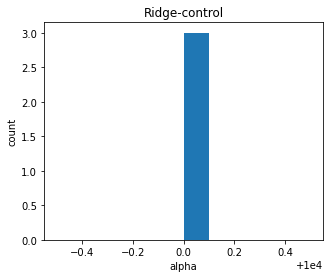

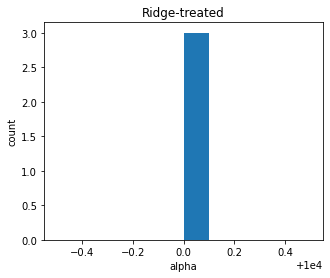

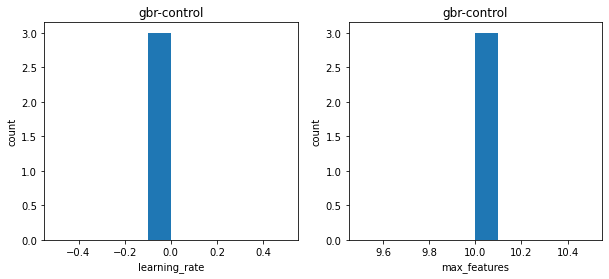

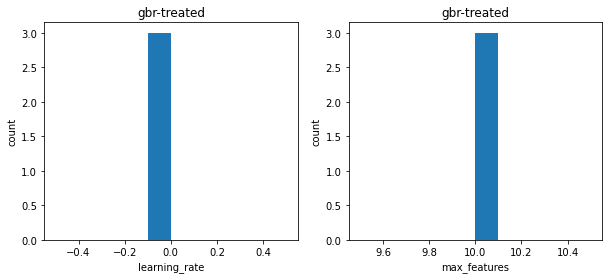

In [16]:
from collections import defaultdict
def hyperparam_distributions(samples) -> {str:[]}:
    """Returns a dict from hyper-parameter name to the best values for that hyper-parameter over the samples."""
    distributions = defaultdict(list)
    for sample in samples:
        h = sample['estimator'].best_params_
        for key, value in h.items():
            distributions[key].append(value)
    return distributions

def plot_hyperparam_distributions(samples, title) -> None:
    distributions = hyperparam_distributions(samples)
    k = len(distributions)
    fig, axes = plt.subplots(1,k,figsize=(k*5,4))
    if k == 1:
        axes = [axes]
    for i, (key, values) in enumerate(distributions.items()):
        ax = axes[i]
        ax.hist(values)
        ax.set_title(title)
        ax.set_xlabel(key)
        ax.set_ylabel('count')
    return fig,axes

for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")